# resave computed feature map. add natsorted to rearrnage the list order

In [1]:
# import the necessary packages
import imutils
import matplotlib.pyplot as plt

import os
import numpy as np
from scipy import ndimage
from tqdm import tqdm  # ! this might result into problem with 'object'
import pandas as pd
import random
import glob
from skimage import io

import argparse
import time
import cv2

In [2]:
# visualization for two images

def subShow(IMG1, IMG2):
    plt.figure()
    plt.axis('off')
    plt.subplot(1,2,1)
    plt.imshow(IMG1, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(IMG2, cmap='gray')
    plt.show()

## Import the raw data 

In [3]:
def readTIF(data_list):
    images = []
    for img in range(len(data_list)):  # whole list
    # for img in glob.glob(os.path.join(data_path, "*.tif")):
        
        im = io.imread(data_list[img])  
        imarray = np.array(im)
        images.append(imarray)  # images, num of slices, channels, img.x, img.y
    return np.asarray(images)

In [4]:
# whole stack path

ALL_PATH = '/bigdata/casus/MLID/zebrafish/all_toxo_mock/'
all_img_list = sorted(glob.glob(ALL_PATH + '/*.tif'))

print(len(all_img_list))

80


In [5]:
# train/ val/ test

NUM_train = 15
NUM_val = 2
NUM_test = 2

trainList = all_img_list[:NUM_train]
valList = all_img_list[NUM_train+1: NUM_train+1+NUM_val]
testList = all_img_list[NUM_train+1+NUM_val+1 : NUM_train+1+NUM_val+1+NUM_test]

# print('train dataset:', trainList)
# print('val & test:', valList, testList)

train_raw = readTIF(trainList)[:,:,1,...]  # take gray channel out 
val_raw = readTIF(valList)[:,:,1,...]
test_raw = readTIF(testList)[:,:,1,...]

print('train:', train_raw.shape)

train: (15, 20, 1040, 1392)


In [6]:
# save innormalized data

intermediate_path = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature/intermediate/'
# intermediate_path = './'
np.save(intermediate_path+'train_raw.npy', train_raw)
np.save(intermediate_path+'test_raw.npy', test_raw)
np.save(intermediate_path+'val_raw.npy', val_raw)

## pre-process the data. normalize, rescale and pad for later scanning

In [6]:
# rescale the gray stack

def rescaleStack(imageStack, MIN, MAX):

    ImageScale = []
    
    for stack in range(imageStack.shape[0]):
        temp = imageStack[stack,...]
        tempScale = np.interp(temp, (temp.min(), temp.max()), (MIN, MAX))
        # print(stack, tempScale.min(), tempScale.max())
        ImageScale.append(tempScale.astype('int'))
    
    return np.asarray(ImageScale)

In [7]:
# visualization for two images

def subShow(IMG1, IMG2):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(IMG1, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(IMG2, cmap='gray')
    plt.show()

In [8]:
# normalize into [0, 1]

def normStack(imageStack):
    
    Range = np.max(imageStack) - np.min(imageStack)
    normTemp = ((imageStack - np.min(imageStack))/Range - 0.5) * 2 
    
    return (normTemp +1)/2

### normalize

In [9]:
# normalize and rescale into [0, 255]

train_norm = []  

for i in range(train_raw.shape[0]):
    tempNorm = train_raw[i,...]
    train_norm.append(normStack(tempNorm)*255)
    
val_norm = []
for i in range(val_raw.shape[0]):
    tempNorm = val_raw[i,...]
    val_norm.append(normStack(tempNorm)*255)

test_norm = []
for i in range(test_raw.shape[0]):
    tempNorm = test_raw[i,...]
    test_norm.append(normStack(tempNorm)*255)

test_norm = np.asarray(test_norm)
val_norm = np.asarray(val_norm)
train_norm = np.asarray(train_norm)

(15, 20, 1040, 1392) 0.0 255.0


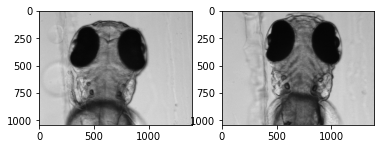

In [10]:
# visualize

print(train_norm.shape, train_norm.min(), train_norm.max())

n_slice = 15
subShow(train_norm[0,n_slice,:,:], val_norm[0, n_slice,:,:])


## 断点1

In [11]:
# 保存再加载，节省内存

del train_raw, val_raw, test_raw

intermediate_path = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature/intermediate/'
# intermediate_path = './'
np.save(intermediate_path+'train_norm.npy', train_norm)
np.save(intermediate_path+'test_norm.npy', test_norm)
np.save(intermediate_path+'val_norm.npy', val_norm)

In [3]:
intermediate_path = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature/intermediate/'

train_norm = np.load(intermediate_path + 'train_norm.npy')
val_norm = np.load(intermediate_path + 'val_norm.npy')
test_norm = np.load(intermediate_path + 'test_norm.npy')

### pad the stacks

In [4]:
def padImg(imageStacks, padW, padH):
    
    stackPad = []

    for stack in range(imageStacks.shape[0]):
        tempStack = imageStacks[stack,...]
        # print('before:', tempStack.max())
        tempMean = np.round(np.mean(tempStack)).astype('int')  # mean of whole stack
        # print(stack, tempMean)
        tempStack = np.pad(tempStack, ((0,0), (padH,0), (padW,0)), 'constant', constant_values=tempMean) 
        # print('after:', tempStack.max())
        stackPad.append(tempStack)
    
    return (np.asarray(stackPad).astype('int'))
    

In [4]:
# padding to avoid artifacts

# window size
(winW, winH) = (64*2, 64*2)

# pad parameters
(padW, padH) = (0, winH)

In [11]:
# pad the images

train_norm_pad = padImg(train_norm[14:15,...], padW, padH)  # 分三次处理7，7，1
val_norm_pad = padImg(val_norm, padW, padH)
test_norm_pad = padImg(test_norm, padW, padH)

print('after pad:', train_norm_pad.shape, train_norm_pad.max())

(15, 20, 1040, 1392)
after pad: (1, 20, 1168, 1392) 255


## 断点2

In [12]:
# del val_norm, test_norm

intermediate_path = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature/intermediate/'

np.save(intermediate_path+'train_norm_pad.npy', train_norm_pad)
# np.save(intermediate_path+'test_norm_pad.npy', test_norm_pad)
# np.save(intermediate_path+'val_norm_pad.npy', val_norm_pad)

In [23]:
intermediate_path = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature/intermediate/'

# train_norm_pad = np.load(intermediate_path + 'train_norm_pad.npy')
val_norm_pad = np.load(intermediate_path + 'val_norm_pad.npy')
test_norm_pad = np.load(intermediate_path + 'test_norm_pad.npy')

In [44]:
# padding to avoid artifacts

# window size
(winW, winH) = (64*2, 64*2)

# pad parameters
(padW, padH) = (0, winH)

In [45]:
# specify the data 

stackPad = test_norm_pad
stackUnpad = test_norm

windows size: 128


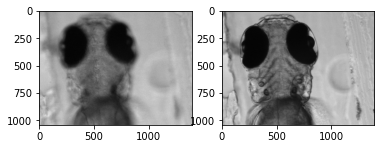

In [46]:
# fetch the patch
# take a patch from two neighbour images

n_stack = 0
# n_slice = random.randint(0, stackPad.shape[1]-1)
n_slice1 = 0
n_slice2 = 19
windowSize = [winW, winH]
print('windows size:', winW)

tempIMG1 = stackPad[n_stack, n_slice1, :, :]
tempIMG2 = stackPad[n_stack, n_slice2, :, :]

tempIMG1_unpad = stackUnpad[n_stack, n_slice1, :, :]
tempIMG2_unpad = stackUnpad[n_stack, n_slice2, :, :]

subShow(tempIMG1_unpad, tempIMG2_unpad)

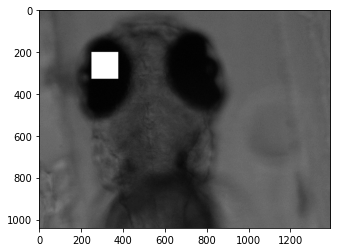

In [48]:
# 找patch的位置

startPoint1 = [200, 250]
startPoint2 = startPoint1

mark = tempIMG1_unpad
mark[startPoint1[0]:startPoint1[0] + windowSize[1], startPoint1[1]:startPoint1[1] + windowSize[0]] = 255
plt.imshow(mark, cmap='gray')

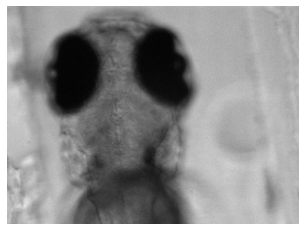

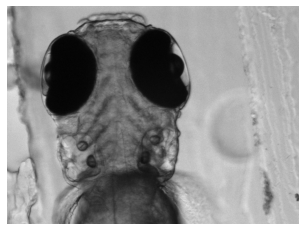

In [14]:
# 保存图片

plt.imshow(tempIMG1_unpad, cmap='gray')
plt.axis('off')
FIG_PATH = '/home/li52/code/LM/digitalConfocal/reports/featureMap/'
plt.savefig(FIG_PATH + 'out_test_0_0.png', dpi=300, bbox_inches = 'tight')

plt.figure()
plt.imshow(tempIMG2_unpad, cmap='gray')
plt.axis('off')
FIG_PATH = '/home/li52/code/LM/digitalConfocal/reports/featureMap/'
plt.savefig(FIG_PATH + 'in_test_0_19.png', dpi=300, bbox_inches = 'tight')

patch max: 116 int64


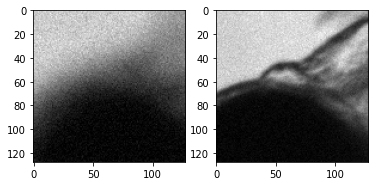

In [49]:
# startPoint1 = [0, 0]
# startPoint2 = [250, 250]

startPoint1 = [200, 250]
startPoint2 = startPoint1

# two patches for comparing
tempPatch1 = tempIMG1[startPoint1[0]:startPoint1[0] + windowSize[1], startPoint1[1]:startPoint1[1] + windowSize[0]]
tempPatch2 = tempIMG2[startPoint2[0]:startPoint2[0] + windowSize[1], startPoint2[1]:startPoint2[1] + windowSize[0]]

print('patch max:', tempPatch1.max(), tempPatch1.dtype)

subShow(tempPatch1, tempPatch2)

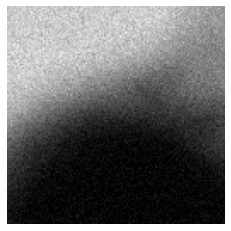

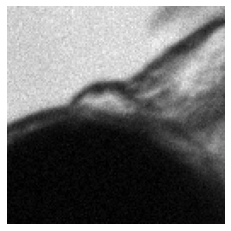

In [15]:
# 保存图片

plt.imshow(tempPatch1, cmap='gray')
plt.axis('off')
FIG_PATH = '/home/li52/code/LM/digitalConfocal/reports/featureMap/'
plt.savefig(FIG_PATH + 'out_test_0_0_patch.png', dpi=300, bbox_inches = 'tight')

plt.figure()
plt.imshow(tempPatch2, cmap='gray')
plt.axis('off')
FIG_PATH = '/home/li52/code/LM/digitalConfocal/reports/featureMap/'
plt.savefig(FIG_PATH + 'in_test_0_19_patch.png', dpi=300, bbox_inches = 'tight')

### Quality inspector

In [50]:
# various blur detectors

import numpy as np
from skimage import filters
import os
import cv2

# brenner detector
def brenner(img):

    imgMat = img/255.0
    
    x, y = imgMat.shape
    score = 0
    for i in range(x - 2):
        for j in range(y - 2):
            score += (imgMat[i + 2, j] - imgMat[i, j]) ** 2

    score=score/10

    return score

# tenengrad detector
def Tenengrad(img):

    f = img
    tmp = filters.sobel(f)
    source=np.sum(tmp**2)
    source=np.sqrt(source)

    return source

# laplacian
def  laplacian(img):

    resLap = cv2.Laplacian(np.uint8(img), cv2.CV_8U)  # adapt to the images, did not change the distributions
    score = resLap.var()
    return score

# SMD
def SMD(img):

    f=img / 255.0 # [0,1]
    x, y = f.shape
    score = 0
    for i in range(x - 1):
        for j in range(y - 1):
            score += np.abs(f[i+1,j]-f[i,j])+np.abs(f[i,j]-f[i+1,j])
    score=score/100
    return score

# SMD2
def SMD2(img):

    f = img/255.0
    x, y = f.shape
    score = 0
    for i in range(x - 1):
        for j in range(y - 1):
            score += np.abs(f[i+1,j]-f[i,j])*np.abs(f[i,j]-f[i,j+1])

    return score

# Variance
def Variance(img):

    f = img
    score = np.var(f)
    return score

# Vollath
def Vollath(img):

    f = img
    source=0
    x,y=f.shape
    for i in range(x-1):
        for j in range(y):
            source+=f[i,j]*f[i+1,j]
    source=source-x*y*np.mean(f)
    
    return source

In [51]:

# brenner
brenner1 = brenner(tempPatch1)
brenner2 = brenner(tempPatch2)
print('brenner:', brenner1, brenner2, np.abs(brenner1-brenner2)/brenner1)
print('relative:', np.round(brenner2/brenner1, 2))

# tenengrad
tenengrad1 = Tenengrad(tempPatch1)
tenengrad2 = Tenengrad(tempPatch2)
print('tenengrad:', tenengrad1, tenengrad2, np.abs(tenengrad1-tenengrad2)/tenengrad1)
print('relative:', np.round(tenengrad2/tenengrad1, 2))

# Laplacian
laplacian1 = laplacian(tempPatch1)
laplacian2 = laplacian(tempPatch2)
print('laplacian:', laplacian1, laplacian2, np.abs(laplacian1-laplacian2)/laplacian1)
print('relative:', np.round(laplacian2/laplacian1, 2))

# SMD
SMD_1 = SMD(tempPatch1)
SMD_2 = SMD(tempPatch2)
print('SMD:', SMD_1, SMD_2, np.abs(SMD_1-SMD_2)/SMD_1)
print('relative:', np.round(brenner2/brenner1, 2))

# SMD2
SMD2_1 = SMD2(tempPatch1)
SMD2_2 = SMD2(tempPatch2)
print('SMD2:', SMD2_1, SMD2_2, np.abs(SMD2_1-SMD2_2)/SMD2_1)
print('relative:', np.round(brenner2/brenner1, 2))

# Variance
Variance1 = Variance(tempPatch1)
Variance2 = Variance(tempPatch2)
print('Variance:', Variance1, Variance2, np.abs(Variance1-Variance2)/Variance1)
print('relative:', np.round(Variance2/Variance1, 2))

# Vollath
Vollath1 = Vollath(tempPatch1)
Vollath2 = Vollath(tempPatch2)
print('Vollath:', Vollath1, Vollath2, np.abs(Vollath1-Vollath2)/Vollath1)
print('relative:', np.round(brenner2/brenner1, 2))

# std
std1 = np.std(tempPatch1)
std2 = np.std(tempPatch2)
print('std:', std1, std2, np.abs(std1-std2)/std1)
print('relative:', np.round(std2/std1, 2))

brenner: 1.1932410611301865 5.057570165321198 3.2385150243915386
relative: 4.24
tenengrad: 6.05316248333587e-17 1.4876227739032966e-16 1.4575959723510914
relative: 2.46
laplacian: 152.91806882619858 249.83612009510398 0.6337907090564892
relative: 1.63
SMD: 6.484156862744501 9.526666666665653 0.4692221160475398
relative: 4.24
SMD2: 7.955094194540519 16.83777008842658 1.1166022270336071
relative: 4.24
Variance: 1248.3986043930054 4680.925387844443 2.749543912795702
relative: 3.75
Vollath: 46113549.0 171594555.0 2.7211309630494935
relative: 4.24
std: 35.332684647405515 68.41728866189045 0.9363739083130879
relative: 1.94


### Same patch for whole stack, specify which metrics

In [7]:
# test on whole stack (0 stack)

patchStack = train_norm_pad[0,...]
# print(patchStack.shape)

# window size
(winW, winH) = (64*2, 64*2)
windowSize = [winW, winH]

# starting point
startPoint1 = [200, 250]

(20, 1168, 1392)


In [11]:
# target

scoreStack = []

base_patch  = patchStack[0,...][startPoint1[0]:startPoint1[0] + windowSize[1], startPoint1[1]:startPoint1[1] + windowSize[0]]  # first is baseline

for i in range(patchStack.shape[0]):
    
    tempPatch = patchStack[i,...][startPoint1[0]:startPoint1[0] + windowSize[1], startPoint1[1]:startPoint1[1] + windowSize[0]]
    
    # brenner
    brenner1 = brenner(base_patch)
    brenner2 = brenner(tempPatch)
    score1 = np.abs(brenner1-brenner2)/brenner1
    # print('brenner:', brenner1, brenner2, np.abs(brenner1-brenner2)/brenner1)

    # tenengrad
    tenengrad1 = Tenengrad(base_patch)
    tenengrad2 = Tenengrad(tempPatch)
    score2 = np.abs(tenengrad1-tenengrad2)/tenengrad1
    # print('tenengrad:', tenengrad1, tenengrad2, np.abs(tenengrad1-tenengrad2)/tenengrad1)

    # Laplacian
    laplacian1 = laplacian(base_patch)
    laplacian2 = laplacian(tempPatch)
    score3 = np.abs(laplacian1-laplacian2)/laplacian1
    # print('laplacian:', laplacian1, laplacian2, np.abs(laplacian1-laplacian2)/laplacian1)

    # SMD
    SMD_1 = SMD(base_patch)
    SMD_2 = SMD(tempPatch)
    score4 = np.abs(SMD_1-SMD_2)/SMD_1
    # print('SMD:', SMD_1, SMD_2, np.abs(SMD_1-SMD_2)/SMD_1)

    # SMD2
    SMD2_1 = SMD2(base_patch)
    SMD2_2 = SMD2(tempPatch)
    score5 = np.abs(SMD2_1-SMD2_2)/SMD2_1
    # print('SMD2:', SMD2_1, SMD2_2, np.abs(SMD2_1-SMD2_2)/SMD2_1)

    # Variance
    Variance1 = Variance(base_patch)
    Variance2 = Variance(tempPatch)
    score6 = np.abs(Variance1-Variance2)/Variance1
    # print('Variance:', Variance1, Variance2, np.abs(Variance1-Variance2)/Variance1)

    # Vollath
    Vollath1 = Vollath(base_patch)
    Vollath2 = Vollath(tempPatch)
    score7 = np.abs(Vollath1-Vollath2)/Vollath1
    # print('Vollath:', Vollath1, Vollath2, np.abs(Vollath1-Vollath2)/Vollath1)

    # std
    std1 = np.std(base_patch)
    std2 = np.std(tempPatch)
    score8 = np.abs(std1-std2)/std1
    # print('std:', std1, std2, np.abs(std1-std2)/std1)
    
    # slice score
    tempScore = [score1, score2, score3, score4, score5, score6, score7, score8]
    scoreStack.append(tempScore)

scoreStack = np.asarray(scoreStack)

#### visualiz the results

In [86]:
# rescale the score data

scoreScale = np.interp(scoreStack, (scoreStack.min(), scoreStack.max()), (0, 1))
print(scoreScale.shape,scoreScale.max())

(20, 8) 1.0


In [115]:
import seaborn as sns

scoreSum = np.sum(scoreScale, axis=0)
scoreSum = np.expand_dims(scoreScale, axis=0)
# scoreSum = scoreSum.reshape(8,1)
print(scoreSum.shape, scoreStack.shape)

# convert into dataFrame
dfSum = pd.DataFrame(scoreScale, columns=['Brenner','Tenengrad','Laplacian','SMD', 'SMD2', 'Variance', 'Vollath', 'Std'])


(1, 20, 8) (20, 8)


In [ ]:
# heatmap for the whole stack patches

ax = sns.heatmap(scoreStack,center=0,cmap="YlGnBu")

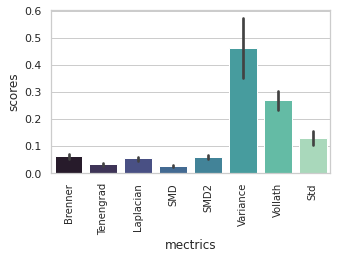

In [125]:
# seaborn. bar plot

fig, ax = plt.subplots(figsize=(5, 3))
g = sns.barplot(data=dfSum, palette="mako",ax=ax)
g.set_xticklabels(g.get_xticklabels(), rotation=90, size = 10)
g.set(xlabel='mectrics', ylabel='scores')
# g.set(ylim=(0, 1))
plt.show()

fig = g.get_figure()
FIG_PATH = '/home/li52/code/LM/digitalConfocal/reports/featureMap/'
fig.savefig(FIG_PATH + 'patchScores.png', dpi=300, bbox_inches = 'tight')

(20, 8)


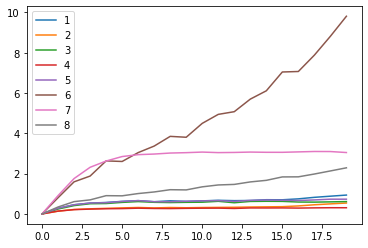

In [27]:
# show the diffrence of the score with plt

# test = scoreStack
print(scoreStack.shape)
plt.plot(scoreStack)
plt.legend(['1', '2','3','4','5','6','7','8'])

## feature maps of stacks

In [19]:
# create the folder to save the stacks

import os

def mkdir(path):
    folder = os.path.exists(path)
    if not folder:                   
        os.makedirs(path)           
    # else:
    #     print('path existed')

In [20]:
# various blur detectors
# input patch-uint8

import numpy as np
from skimage import filters
import os
import cv2

# brenner detector
def brenner(img):
    
    imgMat = img/255.0
    
    x, y = imgMat.shape
    score = 0
    for i in range(x - 2):
        for j in range(y - 2):
            score += (imgMat[i + 2, j] - imgMat[i, j]) ** 2

    score = score/10

    return score

# tenengrad detector
def Tenengrad(img):

    f = img
    tmp = filters.sobel(f)
    source = np.sum(tmp**2)
    source = np.sqrt(source)

    return source

# laplacian
# laplacian
def  laplacian(img):

    resLap = cv2.Laplacian(np.uint8(img), cv2.CV_8U)  # adapt to the images, ddid not change the distributions
    score = resLap.var()
    return score

# SMD
def SMD(img):

    f=img / 255.0 # [0,1]
    x, y = f.shape
    score = 0
    for i in range(x - 1):
        for j in range(y - 1):
            score += np.abs(f[i+1,j]-f[i,j])+np.abs(f[i,j]-f[i+1,j])
    score=score/100
    return score

# SMD2
def SMD2(img):

    f = img/255.0
    x, y = f.shape
    score = 0
    for i in range(x - 1):
        for j in range(y - 1):
            score += np.abs(f[i+1,j]-f[i,j])*np.abs(f[i,j]-f[i,j+1])

    return score

# Variance
def Variance(img):

    f = img
    score = np.var(f)/1000
    
    return score

# Vollath
def Vollath(img):

    f = img
    source = 0
    x,y = f.shape
    for i in range(x-1):
        for j in range(y):
            source += f[i,j]*f[i+1,j]
    source = source - x*y*np.mean(f)
    source = source/100000
    return source

# rescale the image for comparing
def rescaleIMG(img, MIN, MAX):
    temp = np.interp(img, (img.min(), img.max()), (MIN, MAX))
    return temp

In [21]:
# multiple scans for one image with quality detectors.
# input: stack num, slice num, image, step, windowsize, metric: indicate the metric for detecting

import numpy as np
from skimage import filters
import os
import cv2

# one image
def slidingStackQuality(stackNum, sliceNum, image, stepArray, windowSize, savedPath, metric):
    
    focalStack = []
    
    for i in range(len(stepArray)):
        
        stepSize = stepArray[i]
        # slide a window across the image
        feaMap = np.zeros((image.shape[:2]))  # careful the image is 3 channels

        for y in range(0, image.shape[0], stepSize):
            for x in range(0, image.shape[1], stepSize):
                # yield the current window
                yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
                
                tPatch = image[y:y + windowSize[1], x:x + windowSize[0], 0]  # taking only 1 channel from 3
                
                #########
                if metric == 'std':
                    # Roy. calculate the std
                    tempPatch = np.ones((tPatch.shape)) * np.std((tPatch))
                    
                elif metric == 'brenner':
                    # print('cal robert', tPatch.shape, tPatch.min(), tPatch.max())
                    tempPatch = np.ones((tPatch.shape)) * np.round(brenner(tPatch), 2)
                    # print('robert mean:',tempPatch.mean())
                    
                elif metric == 'laplacian':
                    tempPatch = np.ones((tPatch.shape)) * np.round(laplacian(tPatch), 2)
                    
                elif metric == 'tenengrad':
                    tempPatch = np.ones((tPatch.shape)) * np.round(Tenengrad(tPatch), 2)
                    # print('raw tenengrad:', np.unique(tempPatch))
                    
                elif metric == 'SMD':
                    tempPatch = np.ones((tPatch.shape)) * np.round(SMD(tPatch), 2)
                    
                elif metric == 'SMD2':
                    tempPatch = np.ones((tPatch.shape)) * np.round(SMD2(tPatch), 2)
                    
                elif metric == 'Variance':
                    tempPatch = np.ones((tPatch.shape)) * Variance(tPatch)
                    
                    
                elif metric == 'Vollath':
                    tempPatch = np.ones((tPatch.shape)) * np.round(Vollath(tPatch), 2)
                
                #########
                feaMap[y:y + windowSize[1], x:x + windowSize[0]] = tempPatch + feaMap[y:y + windowSize[1], x:x + windowSize[0]]
                
#         focalStack.append(stdMap)       
        # focalStack.append(feaMap[padH:, padW:])  # crop the feature map back 
        focalStack.append(feaMap)
    
                           
    fMax = np.max(np.asarray(focalStack), axis=0)
    # plt.imshow(fMax, cmap='gray')
                           
    # check the saving path
    tempPath = savedPath + '/' + str(stackNum)
    mkdir(tempPath)
    
    # save the max projection in sliceNum under the path 'stackNum'
    np.save(tempPath+'/'+str(sliceNum)+'.npy', fMax)
    print('save sucessfully', sliceNum, tempPath)

In [8]:
# 用之前的原始数据做计算

OLD_PATH = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_partial_15/'
old_train = np.load(OLD_PATH + 'rawGray15.npy')
# print(old_train.shape)

# step size
# stepArray = [8, 10]
stepArray = [8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36]

# window size
(winW, winH) = (64*2, 64*2)

# pad parameters
(padW, padH) = (0, winH)

# saved path
# metricList = ['std', 'brenner', 'tenengrad', 'laplacian', 'SMD', 'SMD2', 'Variance', 'Vollath']  # brenner, SMD, SMD2, Vollath is slow
metric = 'std'

# savedPath = 'E:/LM/LM/digitalConfocal/notebooks/fMax/testResult/qualityDetect/' + str(metric)
# savedPath = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature/train/' + str(metric)
# savedPath = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature/test/' + str(metric)
# savedPath = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature/val/' + str(metric)
savedPath = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/test/' + str(metric)  # 测试扫描的参数
mkdir(savedPath)

# target data
# targetStack = val_norm_pad
# targetStack = train_norm_pad
targetStack = old_train
targetStack = targetStack[:1,...] # 拿出一个stack
print(targetStack.shape, targetStack.max())

(1, 20, 1040, 1392) 95


In [24]:
# parameters for feature map

# step size
# stepArray = [8, 10]
stepArray = [8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36]

# window size
(winW, winH) = (64*2, 64*2)

# pad parameters
(padW, padH) = (0, winH)

# saved path
# metricList = ['std', 'brenner', 'tenengrad', 'laplacian', 'SMD', 'SMD2', 'Variance', 'Vollath']  # brenner, SMD, SMD2, Vollath is slow
metric = 'Variance'

# savedPath = 'E:/LM/LM/digitalConfocal/notebooks/fMax/testResult/qualityDetect/' + str(metric)
# savedPath = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature/train/' + str(metric)
# savedPath = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature/test/' + str(metric)
# savedPath = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature/val/' + str(metric)
savedPath = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/test/' + str(metric)  # 测试扫描的参数
mkdir(savedPath)

# target data
# targetStack = val_norm_pad
# targetStack = train_norm_pad
targetStack = test_norm_pad
targetStack = targetStack[:1,...] # 拿出一个stack
print(targetStack.shape, targetStack.max())

(1, 20, 1168, 1392) 255


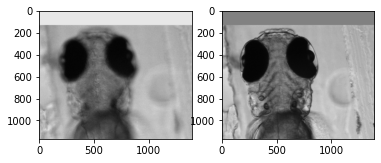

In [9]:
# 检查单张图片

subShow(targetStack[0,0,:,:],targetStack[0,19,:,:])

### calculate feature map

In [10]:
# calculate the stack in metrics

for stackNum in range(targetStack.shape[0]):
    
    for sliceNum in range(targetStack.shape[1]):
        image = np.stack((targetStack[stackNum,sliceNum,...],)*3, axis=-1) 
        for (x, y, window) in slidingStackQuality(stackNum, sliceNum, image, stepArray=stepArray, windowSize=(winW, winH), savedPath=savedPath, metric = metric):
        # if the window does not meet our desired window size, ignore it
            if window.shape[0] != winH or window.shape[1] != winW:
                continue 

save sucessfully 0 /bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/test/Variance/0
save sucessfully 1 /bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/test/Variance/0
save sucessfully 2 /bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/test/Variance/0
save sucessfully 3 /bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/test/Variance/0
save sucessfully 4 /bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/test/Variance/0
save sucessfully 5 /bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/test/Variance/0
save sucessfully 6 /bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/test/Variance/0
save sucessfully 7 /bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/test/Variance/0
save sucessfully 8 /bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/test/Variance/0
save sucessfully 9 /bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/test/Variance/0
save sucessfully 10 /bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/test/Variance/0
save sucessfully 11 /bigdata/casus/MLID/RuiLi/Data/LM

## 检查计算的feature

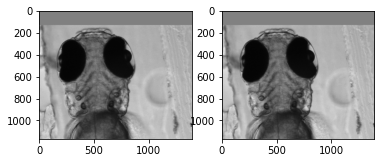

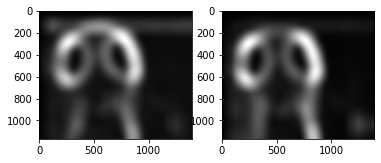

[False  True]
48.241341473891815 191.05209840497065


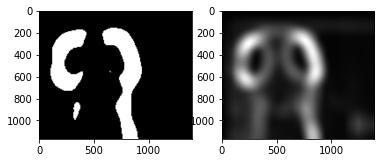

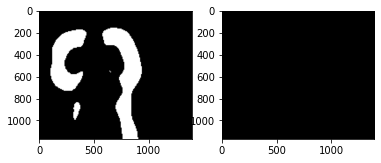

In [25]:
# 检查单张的feature map. variance

from skimage import data,filters

savedPath = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/test/' + 'Variance'

rawIMG1 = targetStack[0,18,:,:]
rawIMG2 = targetStack[0,19,:,:]

feature1 = np.load(savedPath + '/0/0.npy')
feature2 = np.load(savedPath + '/0/19.npy')

subShow(rawIMG1, rawIMG2)
subShow(feature1, feature2)

print(np.unique(np.equal(feature1, feature2)))
print(feature1.mean(), feature2.mean())

# 单张的otsu计算thresh
testMap = feature2
thresh = filters.threshold_otsu(testMap)
binaryOtsu = testMap > (thresh)

subShow(binaryOtsu, testMap)

# 第二张，用19 feaure2的thresh
binaryOtsu2 = feature1 > (thresh)

subShow(binaryOtsu, binaryOtsu2)

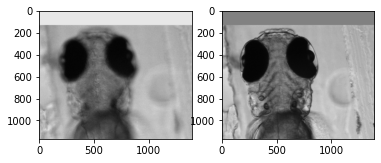

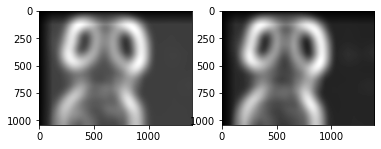

[False]
1088.2109130996441 2151.974657121353


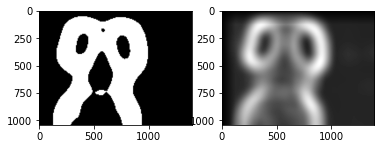

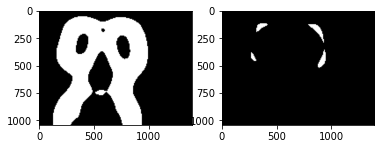

In [20]:
# 检查单张的feature map. std

from skimage import data,filters

savedPath1 = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/test/' + 'std'

rawIMG1 = targetStack[0,0,:,:]
rawIMG2 = targetStack[0,19,:,:]

feature1 = np.load(savedPath1 + '/0/0.npy')
feature2 = np.load(savedPath1 + '/0/19.npy')

subShow(rawIMG1, rawIMG2)
subShow(feature1, feature2)

print(np.unique(np.equal(feature1, feature2)))
print(feature1.mean(), feature2.mean())

# 单张的otsu计算thresh
testMap = feature2
thresh = filters.threshold_otsu(testMap)
binaryOtsu = testMap > (thresh)

subShow(binaryOtsu, testMap)

# 第二张同样的thresh
binaryOtsu2 = feature1 > (thresh)

subShow(binaryOtsu, binaryOtsu2)

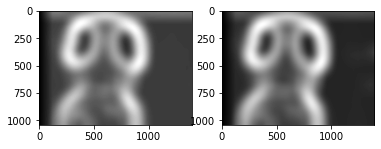

39.49929266136163 75.47873563218391


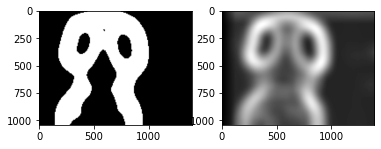

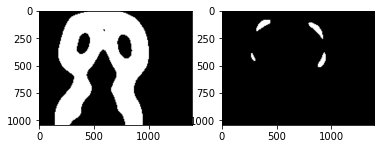

In [21]:
# 对比 old数据的结果
from skimage import data,filters

OLD_PATH = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_partial_15/'
old_results = np.load(OLD_PATH + 'fMaxPad15.npy')

result1 = old_results[0,0,:,:]
result2 = old_results[0,19,:,:]
subShow(result1, result2)
print(result1.mean(), result2.mean())


# 单张的otsu计算thresh
testMap = result2
thresh = filters.threshold_otsu(testMap)
binaryOtsu = testMap > (thresh)

subShow(binaryOtsu, testMap)

# 第二张同样的thresh
binaryOtsu2 = result1 > (thresh)

subShow(binaryOtsu, binaryOtsu2)

## 计算stacks的binary

In [3]:
# binary the mask with otsu in stacks
# use errosion to fill the whole

from skimage import data,filters
from skimage.morphology import reconstruction

def binaryMap(stack, refNUM):
    biStacks = []
    for i in range(stack.shape[0]):
        refMapT = stack[i,refNUM,...]  # refNUM image as reference
        threshT = filters.threshold_otsu(refMapT)
        
        stackT = stack[i,...] > (threshT)
        stackT[:,1039:,:] = 1
        
        # filled the hole
        biStack = []
        for j in range(stackT.shape[0]):
            
            seed = np.copy(stackT[j,...])
            seed[1:-1, 1:-1] = stackT[j,...].max()
            mask = stackT[j,...]

            filledT = reconstruction(seed, mask, method='erosion')
            
            biStack.append(filledT)
            
        biStacks.append(np.asarray(biStack))
    return np.asarray(biStacks)

(1, 20, 1040, 1392)


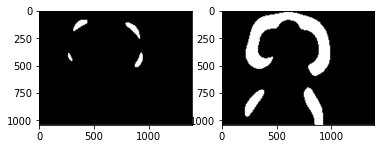

In [4]:
# 对比 old std数据的结果
from skimage import data,filters

OLD_PATH = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_partial_15/'
old_results = np.load(OLD_PATH + 'fMaxPad15.npy')

# 检查其中的一个stack
testStack = old_results[:1,...]
print(testStack.shape)

testBi = binaryMap(testStack, 19)
n_slice = 0
subShow(testBi[0,n_slice,:,:],testBi[0,n_slice+1,:,:])

In [10]:
# 对比 variance 数据的结果
from skimage import data,filters

savedPath1 = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature_intermediate/Variance/'
new_results = np.load(savedPath1 + 'test_2.npy')

# 检查其中的一个stack
testStack = new_results[:1,...]
print(testStack.shape)

testBi = binaryMap(testStack, 19)


(1, 20, 1040, 1392)


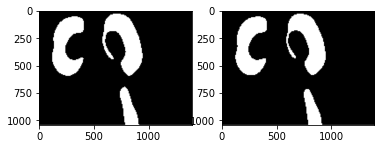

In [17]:
n_slice = 7
subShow(testBi[0,n_slice,:,:],testBi[0,n_slice+1,:,:])

In [30]:
print(feature1.shape, feature1.var())
savedIMG = testStack[0,0,:,:]
print(savedIMG.shape, savedIMG.var())

(1168, 1392) 2177.558737967859
(1040, 1392) 39943.62496216198


## 检查正式计算的和现在的有什么区别

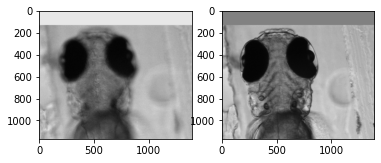

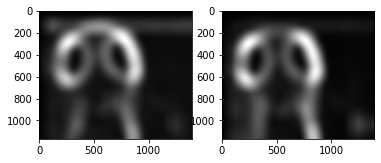

[False  True]
48.241341473891815 191.05209840497065


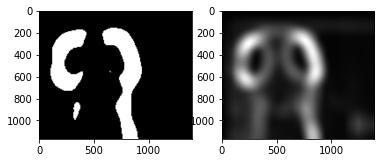

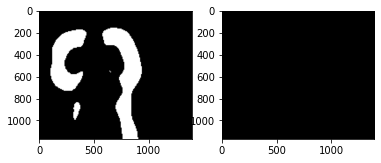

In [33]:
# test计算的variance

from skimage import data,filters

savedPath = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/test/' + 'Variance'

rawIMG1 = targetStack[0,0,:,:]
rawIMG2 = targetStack[0,19,:,:]

feature1 = np.load(savedPath + '/0/0.npy')
feature2 = np.load(savedPath + '/0/19.npy')

subShow(rawIMG1, rawIMG2)
subShow(feature1, feature2)

print(np.unique(np.equal(feature1, feature2)))
print(feature1.mean(), feature2.mean())

# 单张的otsu计算thresh
testMap = feature2
thresh = filters.threshold_otsu(testMap)
binaryOtsu = testMap > (thresh)

subShow(binaryOtsu, testMap)

# 第二张，用19 feaure2的thresh
binaryOtsu2 = feature1 > (thresh)

subShow(binaryOtsu, binaryOtsu2)

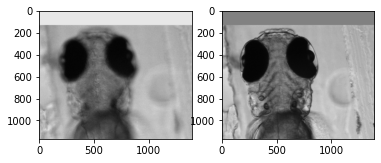

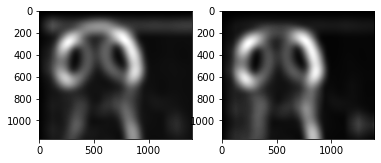

[False  True]
48.26026875688868 191.04481157002832


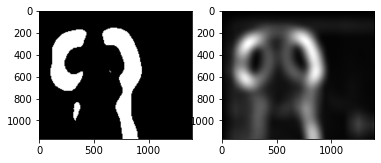

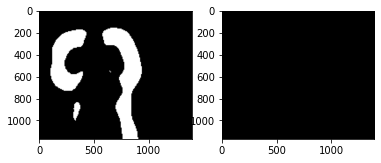

In [32]:
# 正式计算的test

from skimage import data,filters

savedPath = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature/test/' + 'Variance'

rawIMG1 = targetStack[0,0,:,:]
rawIMG2 = targetStack[0,19,:,:]

feature1 = np.load(savedPath + '/0/0.npy')
feature2 = np.load(savedPath + '/0/19.npy')

subShow(rawIMG1, rawIMG2)
subShow(feature1, feature2)

print(np.unique(np.equal(feature1, feature2)))
print(feature1.mean(), feature2.mean())

# 单张的otsu计算thresh
testMap = feature2
thresh = filters.threshold_otsu(testMap)
binaryOtsu = testMap > (thresh)

subShow(binaryOtsu, testMap)

# 第二张，用19 feaure2的thresh
binaryOtsu2 = feature1 > (thresh)

subShow(binaryOtsu, binaryOtsu2)

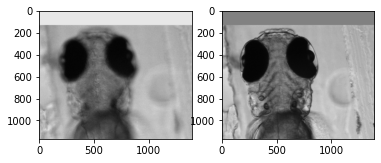

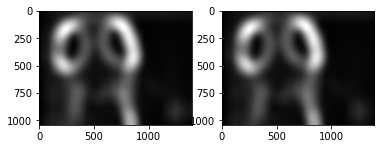

[False  True]
189.68714508731216 178.69157612179478


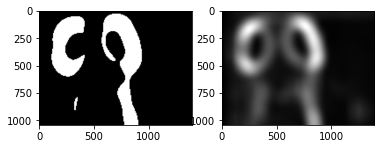

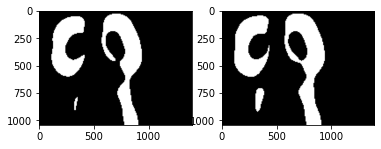

In [35]:
# 正式计算保存的stack

from skimage import data,filters

savedPath = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature_intermediate/' + 'Variance'
savedStack = np.load(savedPath + '/test_2.npy')

rawIMG1 = targetStack[0,0,:,:]
rawIMG2 = targetStack[0,19,:,:]

feature1 = savedStack[0,0,:,:]
feature2 = savedStack[0,19,:,:]

subShow(rawIMG1, rawIMG2)
subShow(feature1, feature2)

print(np.unique(np.equal(feature1, feature2)))
print(feature1.mean(), feature2.mean())

# 单张的otsu计算thresh
testMap = feature2
thresh = filters.threshold_otsu(testMap)
binaryOtsu = testMap > (thresh)

subShow(binaryOtsu, testMap)

# 第二张，用19 feaure2的thresh
binaryOtsu2 = feature1 > (thresh)

subShow(binaryOtsu, binaryOtsu2)

In [ ]:
# test on one image
metric = 'Variance'
# savedPath = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature/val/' + str(metric)
# savedPath = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature/test/' + str(metric)
savedPath = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature/train/' + str(metric)

test = np.load(savedPath + '/0/0.npy')
test1 = test_norm_pad[0,0,:,:]
subShow(test, test1)

## Read in the feature maps from multiple stacks and resave. 重新保存

In [3]:
# define the read in function for max projection
import os
from natsort import natsorted

def readNpy(data_path):
    fStack = []
    for img in natsorted(glob.glob(os.path.join(data_path, "*.npy"))):  # make sure the list is correct
        im = np.load(os.path.join(data_path, img)) 
        # print('image mean:', im.mean())
        # print('image path:', img)
        imarray = np.array(im)
        fStack.append(imarray)  # images, num of slices, channels, img.x, img.y
    return np.asarray(fStack)

# create the folder to save the stacks
def mkdir(path):
    folder = os.path.exists(path)
    if not folder:                   
        os.makedirs(path)           
    else:
        print('path existed:', path)
        
def rescaleStack(imageStack, MIN, MAX):

    ImageScale = []
    
    for stack in range(imageStack.shape[0]):
        temp = imageStack[stack,...]
        tempScale = np.interp(temp, (temp.min(), temp.max()), (MIN, MAX))
        # print(stack, tempScale.min(), tempScale.max())
        ImageScale.append(tempScale.astype('int'))
    
    return np.asarray(ImageScale)

In [24]:
# parameters

# metricList = ['std', 'brenner', 'tenengrad', 'laplacian', 'SMD', 'SMD2', 'Variance', 'Vollath']  # brenner, SMD, SMD2, Vollath is slow
# Variance, std, laplacian
metric = 'laplacian'
# savedPath = 'E:/LM/LM/digitalConfocal/notebooks/fMax/testResult/qualityDetect/' + str(metric)
# savedPath = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature/train/' + str(metric)
savedPath = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature/test/' + str(metric)
# savedPath = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature/val/' + str(metric)

stacksNum = len(os.listdir(savedPath))
print('stacks:', stacksNum)

stacks: 2


In [25]:
# read in multiple stacks

fStacks = []

# for i in range(targetStack.shape[0]):
for i in range(stacksNum):
    print(savedPath+'/'+str(i)+'/')
    fStackTemp = readNpy(savedPath+'/'+str(i)+'/')
    fStacks.append(fStackTemp)
    
fStacks = np.asarray(fStacks)
# fStacks = rescaleStack(fStacks, 0, 255)
print(fStacks.shape, fStacks.dtype, fStacks.max())

/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature/test/laplacian/0/
/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature/test/laplacian/1/
(2, 20, 1168, 1392) float64 122665.94999999991


/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature/test/laplacian/0/0.npy
[False  True]
161.36515756817622 77623.57000000004


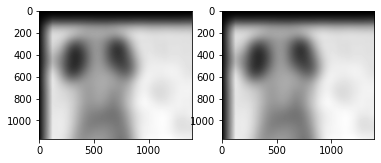

In [26]:
# 检查和源数据是否一致

test = np.interp(fStacks, (fStacks.min(), fStacks.max()), (0, 255))
# test = fStacks.astype('uint8')
# readIMGStack = fStacks[0,0,:,:]
readIMGStack = test[0,0,:,:]

# 手动读入的数据
print(savedPath+'/0/0.npy')
refIMG = np.load(savedPath+'/0/0.npy')

print(np.unique(np.equal(readIMGStack, refIMG)))
print(readIMGStack.max(), refIMG.max())
subShow(readIMGStack, refIMG)


In [27]:
# save the read in file

stackSaved = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature_intermediate/'+ str(metric)
mkdir(stackSaved)
# np.save(stackSaved + '/train_' + str(stacksNum) + '.npy', fStacks.astype('uint8'))  # 存储为uint8会节省空间
fStacks = np.interp(fStacks, (fStacks.min(), fStacks.max()), (0, 255))  # test 要先放缩
np.save(stackSaved + '/test_' + str(stacksNum) + '.npy', fStacks.astype('uint8'))
# np.save(stackSaved + '/val_' + str(stacksNum) + '.npy', fStacks.astype('uint8'))

print('save as:', stackSaved + '/test_' + str(stacksNum) + '.npy')


path existed: /bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature_intermediate/laplacian
save as: /bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature_intermediate/laplacian/test_2.npy


## Visualize feature and patches

In [4]:
# rescale the gray stack

def rescaleStack(imageStack, MIN, MAX):

    ImageScale = []
    
    for stack in range(imageStack.shape[0]):
        temp = imageStack[stack,...]
        tempScale = np.interp(temp, (temp.min(), temp.max()), (MIN, MAX))
        # print(stack, tempScale.min(), tempScale.max())
        ImageScale.append(tempScale.astype('int'))
    
    return np.asarray(ImageScale)

In [73]:
# load in data

# Variance, std, laplacian
# metric = 'Variance'
metric = 'std'
# metric = 'laplacian'
stackSaved = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature_intermediate/'+ str(metric)
intermediate_path = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature/intermediate/'

# load in data. test-2, train-15, val-2
testNUM = 2
# trainNUM = 15
# valNUM = 2

featureStacks = np.load(stackSaved + '/test_' + str(testNUM) + '.npy')
featureStacks = rescaleStack(featureStacks, 0, 255)
print('feature map:', featureStacks.shape,featureStacks.max())

test_norm = np.load(intermediate_path + 'test_norm.npy')
print('gray img:', test_norm.shape, test_norm.max())

feature map: (2, 20, 1040, 1392) 255
gray img: (2, 20, 1040, 1392) 255.0


In [68]:
# 检查laplacian的feature map. laplacian需要做翻转

if metric == 'laplacian':
    featureStacks = 255 - featureStacks

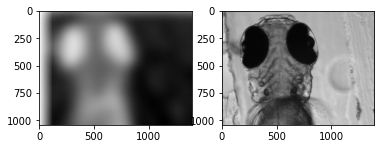

In [58]:
# visualize

subShow(featureStacks[0,19,:,:], test_norm[0, 19, :,:])

In [ ]:
# 是不是显示的时候自动的rescale了
# out focus image
import seaborn as sns

ax = sns.heatmap(featureStacks[1,0,:,:],cmap="YlGnBu")
# ax1 = sns.heatmap(test[1,19,:,:] - test[1,0,:,:],cmap="YlGnBu")

In [ ]:
# on focus image

ax = sns.heatmap(test[1,19,:,:],cmap="YlGnBu")

In [ ]:
# check the difference between in and out-focus

plt.imshow(test[1,19,:,:] - test[1,0,:,:],cmap='gray' )

laplacian


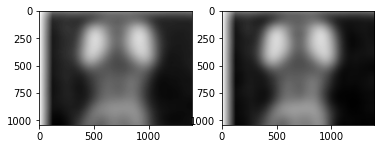

252 252
[False  True]
143.41635720601238 85.84164456233422
255 252


In [37]:
# visualize

print(metric)
subShow((featureStacks[1,17,:,:]), (featureStacks[1,19,:,:]))
print(featureStacks[1,15,:,:].max(), featureStacks[1,19,:,:].max())

print(np.unique(np.equal(featureStacks[0,0,:,:], featureStacks[0,19,:,:])))
print(featureStacks[1,17,:,:].mean(), featureStacks[1,19,:,:].mean())
print(featureStacks[1,17,:,:].max(), featureStacks[1,19,:,:].max())

patch max: 219 219


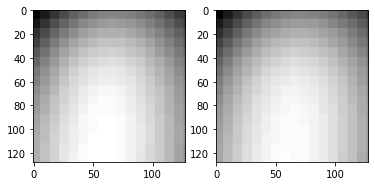

In [52]:
# 展示一个patch内的图像情况

# window size
(winW, winH) = (64*2, 64*2)

# take a patch from two neighbour images
n_stack = 0
# n_slice = random.randint(0, stackPad.shape[1]-1)
n_slice1 = 0
n_slice2 = 19

windowSize = [winW, winH]
# print('windows size:', winW)

startPoint1 = [200, 250]
startPoint2 = startPoint1

tempIMG1 = featureStacks[n_stack, n_slice1, :, :]
tempIMG2 = featureStacks[n_stack, n_slice2, :, :]

# two patches for comparing
tempPatch1 = tempIMG1[startPoint1[0]:startPoint1[0] + windowSize[1], startPoint1[1]:startPoint1[1] + windowSize[0]]
tempPatch2 = tempIMG2[startPoint2[0]:startPoint2[0] + windowSize[1], startPoint2[1]:startPoint2[1] + windowSize[0]]

print('patch max:', tempPatch1.max(), tempPatch2.max())

print('single patch')
subShow(tempPatch1, tempPatch2)

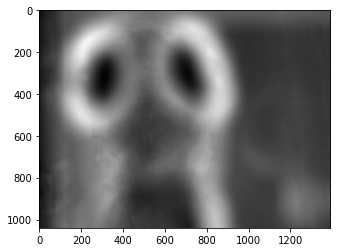

In [74]:
# combine the original images and current images

# out focus

NUM1 = 0  # use the bottom image for the standard seg

testMap1 = featureStacks[0,NUM1,...]
testIMG1 = test_norm[0,NUM1,...]

sumImg1 = 2*testMap1+testIMG1
sumImg1 = np.interp(sumImg1, (sumImg1.min(), sumImg1.max()), (0, 1))

plt.imshow(sumImg1, cmap='gray')

In [ ]:
# 保存图片

plt.imshow(sumImg1, cmap='gray')
plt.axis('off')
FIG_PATH = '/home/li52/code/LM/digitalConfocal/reports/featureMap/'
plt.savefig(FIG_PATH + 'out_laplacian_test_0_0.png', dpi=300, bbox_inches = 'tight')

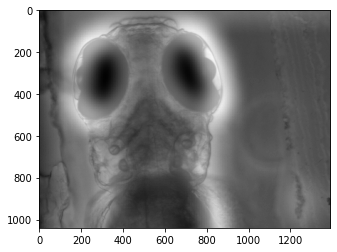

In [75]:
# combine the original images and current images

# in focus

NUM2 = 19  # use the bottom image for the standard seg

testMap2 = featureStacks[0,NUM2,...]
testIMG2 = test_norm[0,NUM2,...]

sumImg2 = 2*testMap2+testIMG2
sumImg2 = np.interp(sumImg2, (sumImg2.min(), sumImg2.max()), (0, 1))

plt.imshow(sumImg2, cmap='gray')

In [ ]:
# 保存图片

plt.imshow(sumImg2, cmap='gray')
plt.axis('off')
FIG_PATH = '/home/li52/code/LM/digitalConfocal/reports/featureMap/'
plt.savefig(FIG_PATH + 'in_laplacian_test_0_0.png', dpi=300, bbox_inches = 'tight')

patch max: 0.7107467602205197 float64


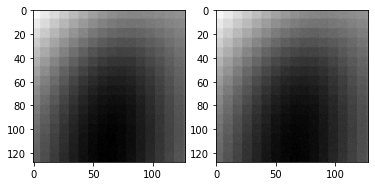

In [76]:
# patch visualization

# startPoint1 = [0, 0]
# startPoint2 = [250, 250]

startPoint1 = [200, 250]
startPoint2 = startPoint1

# two patches for comparing
tempPatch1 = sumImg1[startPoint1[0]:startPoint1[0] + windowSize[1], startPoint1[1]:startPoint1[1] + windowSize[0]]
tempPatch2 = sumImg2[startPoint2[0]:startPoint2[0] + windowSize[1], startPoint2[1]:startPoint2[1] + windowSize[0]]

print('patch max:', tempPatch1.max(), tempPatch1.dtype)

subShow(tempPatch1, tempPatch2)

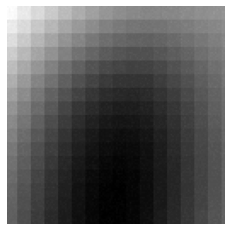

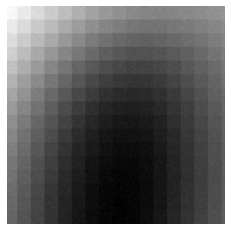

In [77]:
# 保存图片

plt.imshow(tempPatch1, cmap='gray')
plt.axis('off')
FIG_PATH = '/home/li52/code/LM/digitalConfocal/reports/featureMap/'
plt.savefig(FIG_PATH + 'out_std_test_0_0_patch.png', dpi=300, bbox_inches = 'tight')

plt.figure()
plt.imshow(tempPatch2, cmap='gray')
plt.axis('off')
FIG_PATH = '/home/li52/code/LM/digitalConfocal/reports/featureMap/'
plt.savefig(FIG_PATH + 'in_std_test_0_19_patch.png', dpi=300, bbox_inches = 'tight')

## Binary the feature maps into mask

In [4]:
def rescaleStack(imageStack, MIN, MAX):

    ImageScale = []
    
    for stack in range(imageStack.shape[0]):
        temp = imageStack[stack,...]
        tempScale = np.interp(temp, (temp.min(), temp.max()), (MIN, MAX))
        # print(stack, tempScale.min(), tempScale.max())
        ImageScale.append(tempScale.astype('int'))
    
    return np.asarray(ImageScale)

# create the folder to save the stacks
def mkdir(path):
    folder = os.path.exists(path)
    if not folder:                   
        os.makedirs(path)           
    else:
        print('path existed:', path)
        

In [5]:
def readNpyCrop(data_path):
    fStack = []
    for img in glob.glob(os.path.join(data_path, "*.npy")):
        im = np.load(os.path.join(data_path, img)) 
        im = im[128:, :]  # crop the pad pixels
        imarray = np.array(im)
        fStack.append(imarray)  # images, num of slices, channels, img.x, img.y
    return np.asarray(fStack)

In [6]:
# load in data

# Variance, std, laplacian
# metric = 'Variance'
# metric = 'std'
metric = 'laplacian'
stackSaved = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature_intermediate/'+ str(metric)  # where the data was
intermediate_path = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature/intermediate/'

# load in data. test-2, train-15, val-2
testNUM = 2
# trainNUM = 15
# valNUM = 2

featureStacks = np.load(stackSaved + '/val_' + str(testNUM) + '.npy')
print('load dataset:', stackSaved + '/val_' + str(testNUM) + '.npy')


if featureStacks.shape[2] != 1040:
    featureStacks = featureStacks[:,:,128:,:]  # crop the pad
    
    
if metric == 'laplacian':
    featureStacks = np.interp(featureStacks, (featureStacks.min(), featureStacks.max()), (0, 255))
    featureStacks = 255 - featureStacks

# featureStacks = fStacks
# print(featureStacks.shape, featureStacks.max())
# featureStacks = np.load(stackSaved + '/val_' + str(testNUM) + '.npy')
# featureStacks = rescaleStack(featureStacks, 0, 255)
print('feature map:', featureStacks.shape,featureStacks.max())

# OLD_PATH = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_partial_15/'
# old_train = np.load(OLD_PATH + 'rawGray15.npy')

# train_norm = np.load(intermediate_path + 'test_norm.npy')
# train_norm = old_train
# print('gray img:', test_norm.shape, test_norm.max())

load dataset: /bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/feature_intermediate/laplacian/val_2.npy
feature map: (2, 20, 1040, 1392) 255.0


In [7]:
# 检查每一张的区别

testStack1 = featureStacks[0,...]
testStack2 = featureStacks[1,...]

print(testStack1.mean(), testStack1.max(), testStack1.min())
print(testStack2.mean(), testStack2.max(), testStack2.min())

98.18003863779843 255.0 0.0
106.31576830343512 254.55704436549053 12.56804555517931


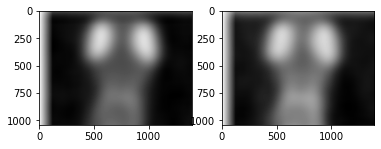

147.67616098741405 255.0 14.807312331910481 251.17173149159447
[False]


In [8]:
temp1 = testStack1[0,...]
temp2 = testStack1[19,...]

tempScale = np.interp(temp1, (temp1.min(), temp1.max()), (0, 255))
subShow(tempScale,temp2)
print(temp1.min(), temp1.max(), temp2.min(), temp2.max())
print(np.unique(np.equal(temp1, temp2)))

stack1


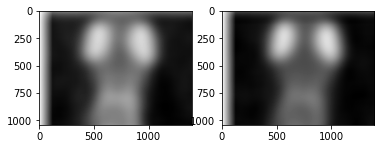

stack2


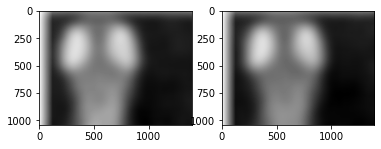

In [9]:
print('stack1')
subShow(testStack1[19,...], testStack1[0,...])

print('stack2')
subShow(testStack2[19,...], testStack2[0,...])

### test on single image

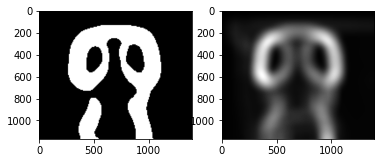

In [15]:
# 单张图片的测定

from skimage import data,filters

NUM = 19  # use the bottom image for the standard seg

testMap = featureStacks[1,NUM,...]
thresh = filters.threshold_otsu(testMap)
binaryOtsu = testMap > (thresh)

# 封闭底部的空腔
# binaryOtsu = binaryOtsu.astype(int)
# binaryOtsu[1039:,...] = 1

subShow(binaryOtsu, testMap)

73
(1168, 1392)


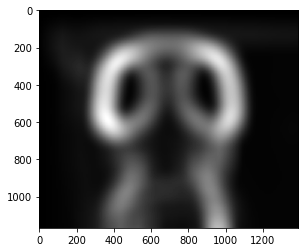

In [16]:
plt.imshow(featureStacks[1,NUM,...], cmap='gray')

print(thresh)
print(featureStacks[1,NUM,...].shape)

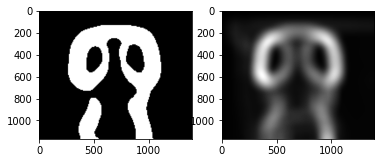

In [12]:
test1 = featureStacks[1,19,...]
binaryTest = test1 > (thresh)

subShow(binaryTest, test1)

### whole stacks binary

In [10]:
# binary the mask with otsu in stacks
# use errosion to fill the whole

from skimage import data,filters
from skimage.morphology import reconstruction

def binaryMap(stack, refNUM):
    biStacks = []
    for i in range(stack.shape[0]):
        refMapT = stack[i,refNUM,...]  # refNUM image as reference
        threshT = filters.threshold_otsu(refMapT)
        
        stackT = stack[i,...] > (threshT)
        stackT[:,1039:,:] = 1
        
        # filled the hole
        biStack = []
        for j in range(stackT.shape[0]):
            
            seed = np.copy(stackT[j,...])
            seed[1:-1, 1:-1] = stackT[j,...].max()
            mask = stackT[j,...]

            filledT = reconstruction(seed, mask, method='erosion')
            # filledT = mask # variance的操作
            
            biStack.append(filledT)
            
        biStacks.append(np.asarray(biStack))
    return np.asarray(biStacks)

In [ ]:
# 多次的计算

test = featureStacks[:15,...]
print(test.shape, test.dtype)
testStacks = binaryMap(test, 19)

print(testStacks.shape, testStacks.dtype)
plt.imshow(testStacks[0,18,:,:], cmap='gray')
np.save('variance_10.npy', testStacks.astype('uint8'))

# 多次的计算

test = featureStacks[10:15,...]
print(test.shape, test.dtype)
testStacks = binaryMap(test, 19)

print(testStacks.shape, testStacks.dtype)
plt.imshow(testStacks[0,18,:,:], cmap='gray')
np.save('variance_10_15.npy', testStacks.astype('uint8'))

# 拼接

temp1 = np.load('variance_10_15.npy')
temp2 =np.load('variance_10.npy')

biStacks = np.vstack([temp2, temp1])
print(biStacks.shape)

laplacian (2, 20, 1040, 1392)


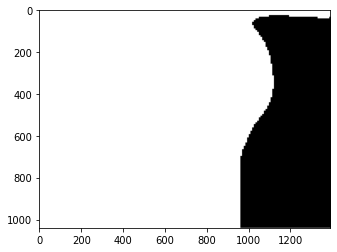

In [11]:
# normal cal on whole stack

biStacks = binaryMap(featureStacks, 19)  # use the last as standard
print(metric, biStacks.shape)
plt.imshow(biStacks[0,4,:,:], cmap='gray')

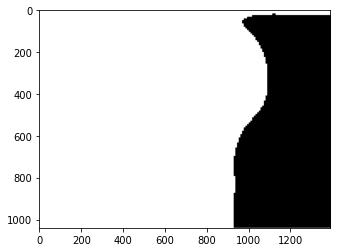

In [17]:
plt.imshow(biStacks[0,19,:,:], cmap='gray')

In [18]:
# save the data
Mask_save_path = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/final/val/'
# Mask_save_path = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/final/test/'
# Mask_save_path = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/final/train/'
mkdir(Mask_save_path)
np.save(Mask_save_path + 'val_mask_' + str(metric) + '.npy', biStacks.astype('uint8'))
print('save as:', Mask_save_path + 'val_mask_' + str(metric) + '.npy')

path existed: /bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/final/val/
save as: /bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_15_2_2/final/val/val_mask_laplacian.npy
